In [125]:
# Practice based on:
# 1. https://course.fast.ai/Lessons/lesson10.html
# 2. https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb
# 3. https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb

In [2]:
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from huggingface_hub import login
from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import LMSDiscreteScheduler
from diffusers import AutoencoderKL, UNet2DConditionModel
from tqdm.auto import tqdm
import os
from fastdownload import FastDownload
from torchvision import transforms as tfms

logging.disable(logging.WARNING)

torch.manual_seed(1)
# from google.colab import userdata
# os.environ["huggingface"] = userdata.get("huggingface")
if not (Path.home()/'.cache/huggingface'/'token').exists(): login(os.environ["huggingface"])
from IPython.display import display

In [3]:
# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [4]:
scheduler = LMSDiscreteScheduler(beta_schedule="scaled_linear", num_train_timesteps=1000)

In [5]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to(torch_device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [6]:
# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to(torch_device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to(torch_device)

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [7]:
height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

In [8]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to(torch_device))[0].half()

def mk_img(t):
    image = (t/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

In [10]:
def mk_samples(prompts, neg_prompts=None, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    # uncond = text_enc([""] * bs, text.shape[1])
    # emb = torch.cat([uncond, text])


    # Adding negative prompt condition
    if not neg_prompts: uncond =  text_enc([""] * bs, text.shape[1])
    # Adding an unconditional prompt , helps in the generation process
    else: uncond = text_enc(neg_prompts, text.shape[1])
    emb = torch.cat([uncond, text])

    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(torch_device).half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        # predict the noise residual
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # perform guidance
        pred = u + g*(t-u)

        # compute the "previous" noisy sample
        latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

<ipython-input-10-564a430bed09>:16: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

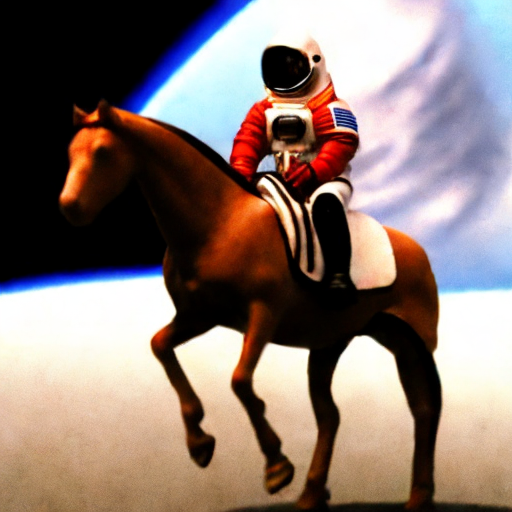

In [20]:
# Display the images

prompts = [
    'a photograph of an astronaut riding a horse'
]

images = mk_samples(prompts)
for img in images: display(mk_img(img))

<ipython-input-10-564a430bed09>:16: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

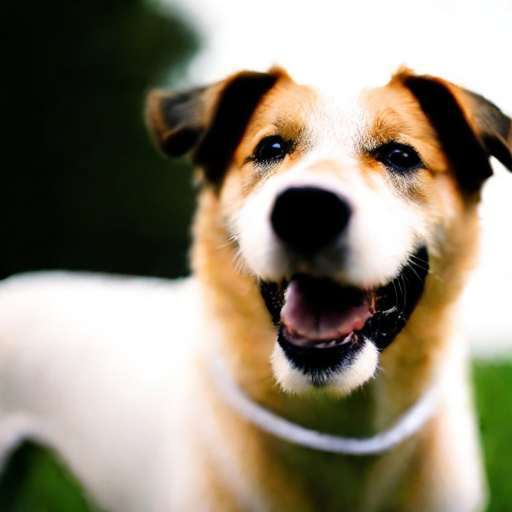

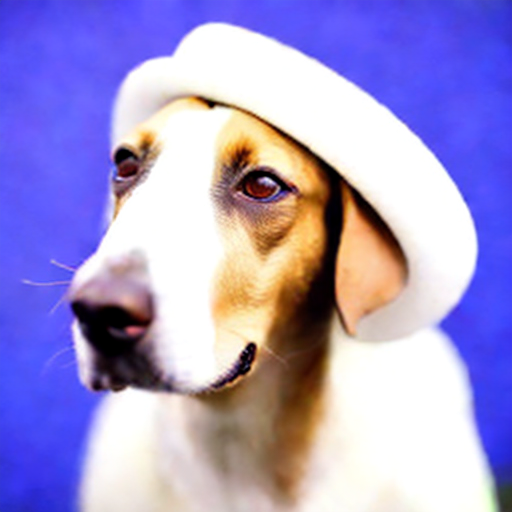

In [23]:
# Practice1: Negative prompts
# Display the images

prompts = [
    'dog wearing a white hat',
    'dog wearing a white hat'
]
neg_prompts = [
    'white hat',
    ''
]

images = mk_samples(prompts, neg_prompts)
for img in images: display(mk_img(img))

In [ ]:
# Practice2: Image to Image

In [36]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        input_tensor = tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device).type(torch.float16)
        latent = vae.encode(input_tensor * 2 - 1)  # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

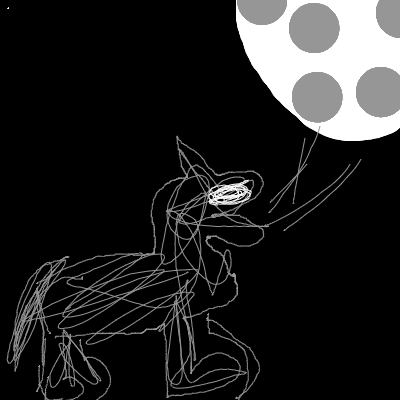

In [40]:
p = FastDownload().download('https://cdn-uploads.huggingface.co/production/uploads/1664665907257-noauth.png')
init_image = Image.open(p).convert("RGB")
init_image

In [41]:
encoded = pil_to_latent(init_image)
encoded.shape

torch.Size([1, 4, 50, 50])

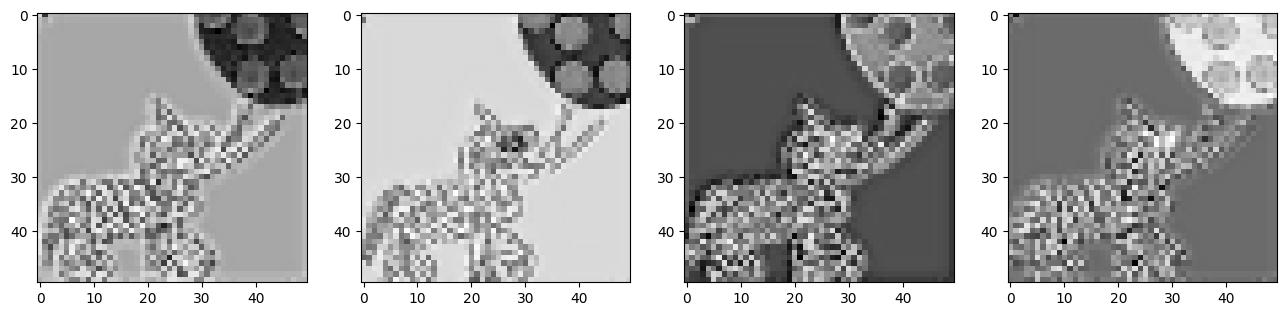

In [42]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

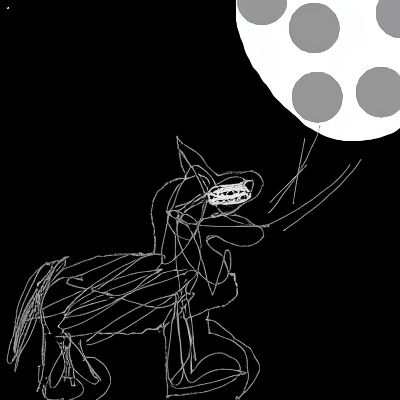

In [43]:
# Decode this latent representation back into an image
decoded = latents_to_pil(encoded)[0]
decoded

In [87]:
def mk_samples(prompts, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    uncond = text_enc([""] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    if seed: torch.manual_seed(seed)

    scheduler.set_timesteps(steps)

    # Prep latents (noising appropriately for start_step)
    start_step = 7
    start_sigma = scheduler.sigmas[start_step]
    noise = torch.randn_like(encoded)
    latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
    latents = latents.to(torch_device).half()

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        if i >= start_step: # << This is the only modification to the loop we do
          inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
          # predict the noise residual
          with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

          # perform guidance
          pred = u + g*(t-u)

          # compute the "previous" noisy sample
          latents = scheduler.step(pred, ts, latents).prev_sample

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

  0%|          | 0/70 [00:00<?, ?it/s]

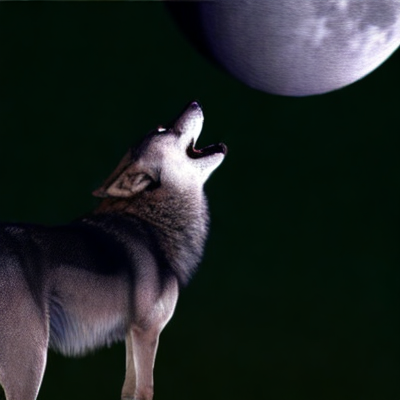

In [88]:
# Display the images

prompts = [
    'Wolf howling at the moon, photorealistic 4K'
]

images = mk_samples(prompts)
for img in images: display(mk_img(img))

In [89]:
# Practice 3: Latents and callbacks

In [120]:
callback_imgs = []

def latents_callback(i, t, latents):
    callback_imgs.extend(latents_to_pil(latents))

In [121]:
def mk_samples(prompts, neg_prompts=None, g=7.5, seed=100, steps=70):
    bs = len(prompts)
    text = text_enc(prompts)
    # uncond = text_enc([""] * bs, text.shape[1])
    # emb = torch.cat([uncond, text])


    # Adding negative prompt condition
    if not neg_prompts: uncond =  text_enc([""] * bs, text.shape[1])
    # Adding an unconditional prompt , helps in the generation process
    else: uncond = text_enc(neg_prompts, text.shape[1])
    emb = torch.cat([uncond, text])

    if seed: torch.manual_seed(seed)

    latents = torch.randn((bs, unet.in_channels, height//8, width//8))
    scheduler.set_timesteps(steps)
    latents = latents.to(torch_device).half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        # predict the noise residual
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)

        # perform guidance
        pred = u + g*(t-u)

        # compute the "previous" noisy sample
        latents = scheduler.step(pred, ts, latents).prev_sample
        # callback_steps = 10
        if i % 10 == 0:
          latents_callback(i, ts, latents)

    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

<ipython-input-121-b531c163dd9b>:16: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, height//8, width//8))


  0%|          | 0/70 [00:00<?, ?it/s]

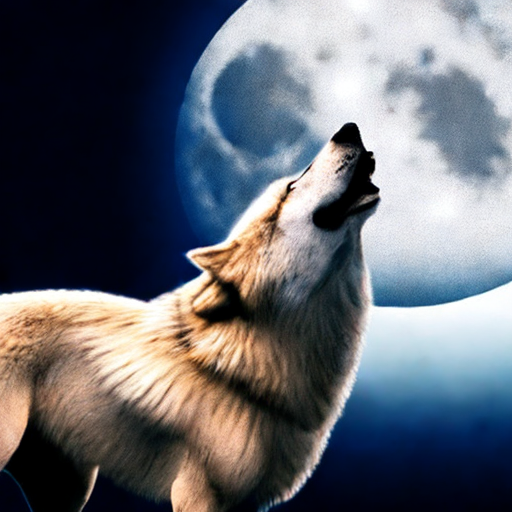

In [122]:
# Display the images

prompts = [
    'Wolf howling at the moon, photorealistic 4K'
]

images = mk_samples(prompts)
for img in images: display(mk_img(img))

In [ ]:
# Display the callback images

In [123]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

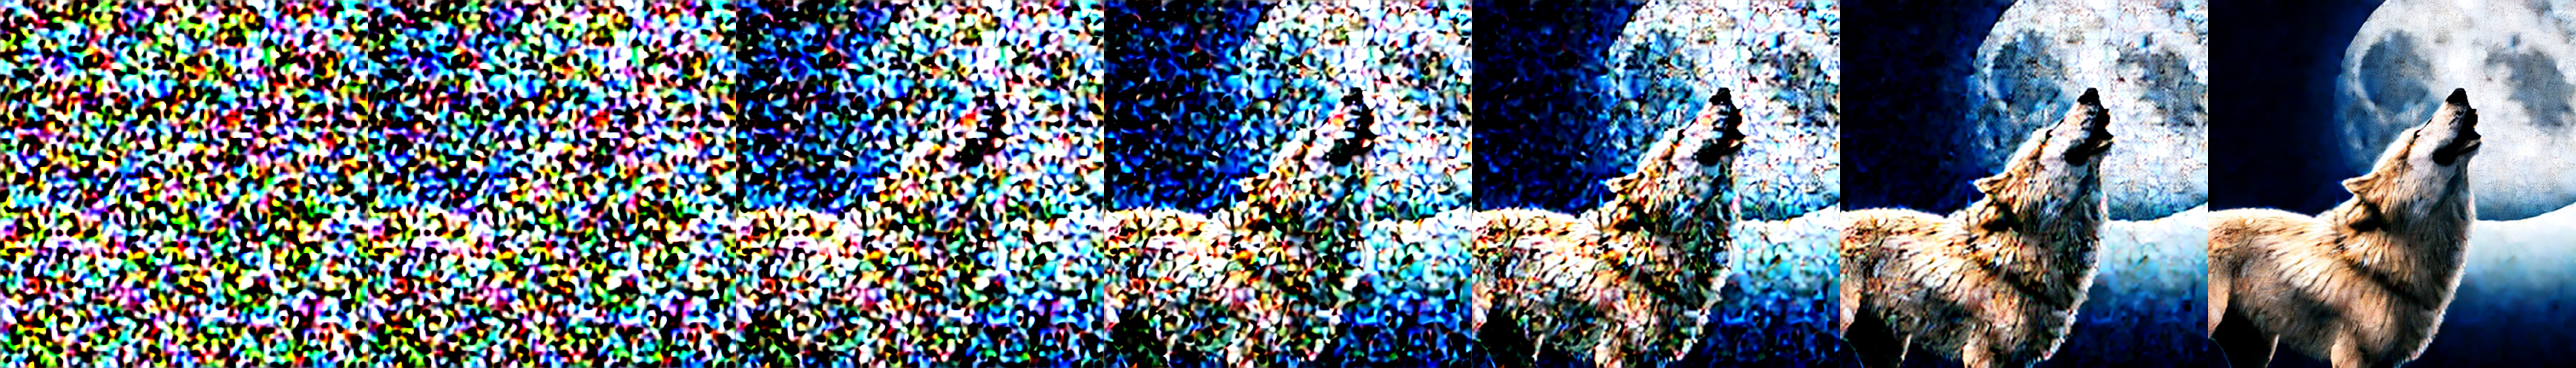

In [124]:
image_grid(callback_imgs, rows=1, cols=len(callback_imgs))